# __**BLOCK 1**__

# 1. Training and testing the model.

## Data
### For our project the data to create the machine learning model was obtained from one of the main platforms for Data Scientists (Kaggle). It consists in a Data set of 422419 cells with classifed news along with other data which is not relevant for our purpose (the publisher, the URL, the host name...). 
### The news are classified in the following categories:
#### b : business
#### t : science and technology 
#### e : entertainment 
#### m : health

https://www.kaggle.com/uciml/news-aggregator-dataset/version/1#uci-news-aggregator.csv

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing

## Important! To be able to run the code in your computer, the data set file should be downloaded and place it in a folder called data

In [2]:
#The data set which should be downloded from github
path_file= './data/dataset_news.csv'
file=pd.read_csv(path_file, sep=',')

# 1.1 Checking the data


## 1.1.1 Missing values
There are 2 missing values in the Publisher field. However, nothing will be done with the missing data as this column is not relevant for the training of the model.

In [3]:
# Number of missing values in each column.
table=pd.DataFrame(file.isna().sum()).rename(columns = {0: 'total'})
print(table)
file[file.isnull().any(axis=1)]

           total
ID             0
TITLE          0
URL            0
PUBLISHER      2
CATEGORY       0
STORY          0
HOSTNAME       0
TIMESTAMP      0


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
4556,4557,Federal Prosecutors Want Cash From Denver Pot ...,http://denver.cbslocal.com/2014/03/10/federal-...,NaN,b,d__jcKruuebDhTMfkhbUJpI3MBjEM,denver.cbslocal.com,1394565833004
14203,14204,Honda Recalls Nearly 900000 Minivans,http://dfw.cbslocal.com/2014/03/16/honda-recal...,NaN,t,dRxWun-PlDEkGpMTSH5m3mrA0rO2M,dfw.cbslocal.com,1395062073951


In [4]:
#Shape of the data set
file.shape

(422419, 8)

## 1.1.2 Bar graph which shows the number of news of each class

In [5]:
#Another column is created in order to translate the meaning of 'b', 't', 'e' and 'h'
category2=[]
for row in file['CATEGORY']:
    if row=='b':
        category2.append('business')
    elif row=='t':
        category2.append('science and technology')
    elif row== 'e':
        category2.append('entertainment')
    else:
        category2.append('health')
file['CATEGORY2'] = category2
file.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,CATEGORY2
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698,business
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207,business
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550,business
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793,business
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027,business


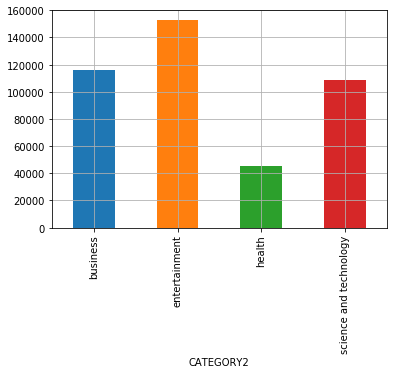

In [6]:
#Graph which shows the number of news from each class. The entertainment class is the most frequent category in 
#the data set. Therefore, the model will be more specialized in entertainment news.
import numpy as np
import matplotlib.pyplot as plt

file_group=file.groupby(by='CATEGORY2').count()
file_group['ID'].plot(kind='bar', grid=True)

## 1.1.3 Analyzing the publishers of the news

In [7]:
#This shows the media companies which most contribute with news to the data set. These are the top 20.
file_group=file.groupby(by='PUBLISHER').count()
file_group['ID'].sort_values(ascending = False).head(20)

PUBLISHER
Reuters                     3902
Huffington Post             2455
Businessweek                2395
Contactmusic.com            2334
Daily Mail                  2254
NASDAQ                      2228
Examiner.com                2085
Los Angeles Times           1976
GlobalPost                  1975
RTT News                    1798
TheCelebrityCafe.com        1699
Entertainmentwise           1600
Forbes                      1550
Bloomberg                   1495
MarketWatch                 1460
TIME                        1436
New York Daily News         1428
PerezHilton.com             1427
Headlines \& Global News    1417
CBS Local                   1388
Name: ID, dtype: int64

## 1.1.4 Preparing the data

In [8]:
#A function is created to normalize the text, removing punctuation symbols and double spaces. This cleaned data is 
#saved in a new column ('TEXT').
def normalize_text(text):
    text = text.lower()
    
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    text = re.sub('\s\W',' ',text)
    text = re.sub('\W\s',' ',text)
    
    # make sure we didn't introduce any double spaces
    text = re.sub('\s+',' ',text)
    
    return text

file['TEXT'] = [normalize_text(text) for text in file['TITLE']]


In [9]:
#The text is vectorized. For more information related to the text 
#vectorization see:http://scikit-learn.org/stable/modules/feature_extraction.html
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(file['TEXT'])
encoder = LabelEncoder()
y = encoder.fit_transform(file['CATEGORY'])

# 1.2 Training and analysis of the model.

## 1.2.1 Stratified K-Fold Cross Validation
In some cases, there may be a large imbalance in the response variables. For example, in dataset concerning price of houses, there might be large number of houses having high price. Or in case of classification, there might be several times more negative samples than positive samples. For such problems, a slight variation in the K Fold cross validation technique is made, such that each fold contains approximately the same percentage of samples of each target class as the complete set, or in case of prediction problems, the mean response value is approximately equal in all the folds. This variation is also known as Stratified K Fold.

### For more information see:
https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f

https://towardsdatascience.com/balancing-bias-and-variance-to-control-errors-in-machine-learning-16ced95724db

In [10]:
### the data is splitted using the Strtified K fold.
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
i=1
score_mean=[]

for train_index,test_index in kf.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #Naive Bayes model
    nb = MultinomialNB()
    classifier_model = nb.fit(X_train, y_train)
    score = nb.score(X_test, y_test)
    score_mean.append(score)
    print(score)
    i+=1
print('The mean of the whole predictions is:',sum(score_mean)/len(score_mean))
    

0.92528939706
0.926993821462
0.926188954383
0.926615060483
0.927370863122
0.927015766299
0.928294114862
0.928008333136
0.926895670084
0.926537086579
The mean of the whole predictions is: 0.926920906747


## 1.2.2 Confussion matrix representation
In the below code, a multiclass confusion matrix is plotted.
Each row of the matrix represents the results of prediction for the corresponding class at that row, while each column represents the actual class. The diagonal cells show the number of correct classifications by the trained classifier, while the off diagonal cells represent the misclassified predictions.
As it is showed in the below plot, the trained classifies correctly 10462 business news, 14670 entertainment news, 4176 health news and 9828 science and technology news. 

In [11]:
#Creation of the confussion matrix
cm = confusion_matrix(y_test, nb.predict(X_test))
cm = np.round(cm,0)
cm

array([[10462,   221,   170,   743],
       [  191, 14670,    87,   298],
       [  163,   143,  4176,    81],
       [  690,   201,   115,  9828]])

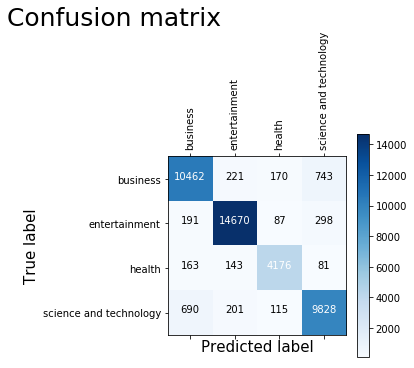

In [12]:
#Plotting the confussion matrix created in the previous code
plt.matshow(cm)

list_news= ['business','entertainment','health','science and technology']

plt.title('Confusion matrix', x=-0.3, y=1.7, fontsize='25')
plt.colorbar()
plt.ylabel('True label', fontsize='15')
plt.xlabel('Predicted label', fontsize='15')


tick_marks = np.arange(len(list_news))
plt.xticks(tick_marks, list_news, rotation=90)
plt.yticks(tick_marks, list_news)

#The array of the confussion matrix (cm) is represented on the graph plotted previously.
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j,i, str(cm[i][j]), horizontalalignment='center', color='white' if i==j else 'black')
        
plt.set_cmap('Blues')
plt.show()

### Adding the recall and the precission to the confusion matrix

## Recall, precision and accuracy

An additional column for the precision and another row for the recall were added to the matrix.
The results of the recall and the precision are showed below:<br>
- The recall for the business news is 91% and the precission 90%<br>
- The recall for the entertainment news is 96% and the precission 96%<br>
- The recall for the health news is 92% and the precission 92%<br>
- The recall for the science and technology news is 90% and the precission 91%<br>

Moreover, the accurcy, which was also calculated in previous cells is 93%.

It can be considerer that the trained model is having a good performance as the diferent analyzed metrics showed good results.

In [14]:
#A column for the recall and for the precision is created.
#The precision column is created
cm_column_precision=[]
for i in range(len(cm)):
    for j in range(len(cm)):
        if i==j:
            cm_column_precision.append([cm[i,j]/sum(cm[:,i])])
cm_column_precision=np.asarray(cm_column_precision).reshape(1,len(cm))
cm_column_precision=np.round(cm_column_precision,3)

#The recall column is created
cm_row_recall=[]
for i in range(len(cm)):
    for j in range(len(cm)):
        if i==j:
            cm_row_recall.append([cm[i,j]/sum(cm[i])])
cm_row_recall=np.asarray(cm_row_recall).reshape(len(cm),1)

#the 'cm' and the 'cm_column_precision' is joined together and this new array is called cm_join_1.
cm_join_1= np.append(cm, cm_column_precision).reshape(len(cm)+1,len(cm))
#The acurracy is added to the cm_row_recall. The accurcy is calculated dividing the true positives/all the predictions.
#This new array is called cm_rows_with_accuracy

true_positives=[]
for i in range(len(cm)):
    for j in range(len(cm)):
        if i==j:
            true_positives.append(cm[i,j])
true_positives=sum(true_positives)

predictions=[]
for i in range(len(cm)):
    for j in range(len(cm)):
        predictions.append(cm[i,j])
predictions=sum(predictions)
predictions

cm_rows_with_accuracy= np.append(cm_row_recall,true_positives/predictions)
#The array is rounded to 3 decimales
cm_rows_with_accuracy=np.round(cm_rows_with_accuracy,3)

#The 'cm_join_1' is joined with the 'cm_rows_with_accuracy' and the new array is called 'cm_join'
join=[]
for i in range(len(cm_join_1)):
    join.append(np.append(cm_join_1[i], cm_rows_with_accuracy[i]))
cm_join=np.asarray(join)
cm_join


array([[  1.04620000e+04,   2.21000000e+02,   1.70000000e+02,
          7.43000000e+02,   9.02000000e-01],
       [  1.91000000e+02,   1.46700000e+04,   8.70000000e+01,
          2.98000000e+02,   9.62000000e-01],
       [  1.63000000e+02,   1.43000000e+02,   4.17600000e+03,
          8.10000000e+01,   9.15000000e-01],
       [  6.90000000e+02,   2.01000000e+02,   1.15000000e+02,
          9.82800000e+03,   9.07000000e-01],
       [  9.09000000e-01,   9.63000000e-01,   9.18000000e-01,
          8.98000000e-01,   9.27000000e-01]])

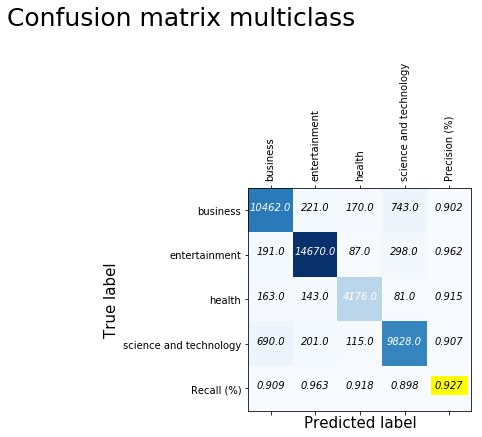

In [16]:
#The data 'cm_join' is represented in a plot.
plt.matshow(cm_join)

list_news_rows= ['business','entertainment','health','science and technology','Recall (%)']
list_news_columns= ['business','entertainment','health','science and technology', 'Precision (%)']

plt.title('Confusion matrix multiclass', x=-0.3, y=1.7, fontsize='25')
plt.ylabel('True label', fontsize='15')
plt.xlabel('Predicted label', fontsize='15')

tick_marks = np.arange(len(cm_join))
plt.xticks(tick_marks, list_news_columns, rotation=90)
plt.yticks(tick_marks, list_news_rows)

#The data is plotted in the confussion matrix
for i in range(len(cm_join)):
    for j in range(len(cm_join)):
        if i==j and j<len(cm_join)-1:
            plt.text(j,i, str(cm_join[i][j]), horizontalalignment='center', fontstyle='oblique', color='white')
        elif i==j==len(cm_join)-1:
            plt.text(j,i, str(cm_join[i][j]), backgroundcolor='yellow', horizontalalignment='center', fontstyle='oblique', color='black')
        else:
            plt.text(j,i, str(cm_join[i][j]), horizontalalignment='center', fontstyle='oblique', color='black')
        
        
plt.set_cmap('Blues')
#plt.figure(figsize = (100,50))
plt.show()


## 1.2.3 ROC curve for a multiclass classificator

The ROC curve shows how the true positive rate (recall) vs False positive rate changes as the threshold is varied.

The model’s ROC curve can be quantified by calculating the total Area Under the Curve (AUC), a metric which falls between 0 and 1 with a higher number indicating better classification performance. In the below graph, the entertainment class is the curve with the greater area, meaning the model performance for the entertaiment class is better at achieving a blend of precision and recall. A random classifier (dashed line) achieves an AUC of 0.5.

Note that the results obtained in the AUC analysis are pretty good as all values are close to 1. Therefore, the blend between recall and precision is much than satisfactory for our model.

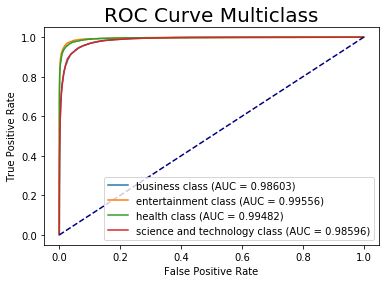

In [17]:
#A ROC curve multiclasss
# calculate roc curve
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class. 
#To perform the ROC curve, the False positive rate and the True positve rate have to be calculated for each class.
classes= ['business','entertainment','health','science and technology']
#The y_predict_probabilities are classified with the model created (classifier_model) and the 'X_test' values.
y_predict_probabilities = classifier_model.predict_proba(X_test)
#False positive rate
fpr = dict()
#True positive rate
tpr = dict()
roc_auc = dict()

for i in range (len(classes)):
    #As the y_test has just an array, the get_dummies is used to have an array with 4 lists.
    #The y_predict_probabilities has already 4 lists in the array. Therefore, no operation is needed.
    #The 4 values come from the number of classes and it is used to calculate 4 different values of tpr.
    #one for each class.
    #The fpr is modified by the different threshold values. To calculate this, the y_test and the y_predict_probabilities
    #need to have the same dimensions. For this reason, the get_dummies is performed, in order to add 4 dimensions to
    #the y_test
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], y_predict_probabilities[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i],tpr[i], label= '%s class (AUC = %0.5f)' % (classes [i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Multiclass', size=20)
plt.legend(loc="lower right")    
    

#### For more informtion about the ROC curve and the threshold see these links:
ROC curve
    http://benalexkeen.com/scoring-classifier-models-using-scikit-learn/
        
Threshold and ROC curve
https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

# 1.3 Let's try the model

### The below code is just for myself understanding

In [1]:
#The code sort the letters alphabetically. The 'b' is given the 0 position, the 'e' is given the 1 position, the 
#'h' is given the 2 position and the 'sc' is given the 3 position.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["b", "sc", "e", "h"])

list(le.inverse_transform([2]))

['h']

### Testing the model

In [18]:
from sklearn import preprocessing
#Text to be tested.
text_news="""Robbie Rotten, has died aged 43 from cancer. Stefansson was best known for his role on the children's show,
which was produced from 2004 to 2014. He was initially diagnosed with pancreatic cancer in 2016, but said it had been 
removed with surgery. He often shared his treatment and progress with fans online on social media - announcing in March 
the disease had returned and was inoperable. \"It's not until they tell you you're going to die soon that you realise 
how short life is. Time is the most valuable thing in life because it never comes back. And whether you spend it in the 
arms of a loved one or alone in a prison cell, life is what you make of it. Dream big,\" he posted to Twitter. 
In June his wife Steinunn Olina revealed the father-of-four's cancer was in its final stages."""
#A codified label is created.
le = preprocessing.LabelEncoder()
#We fill the previous codified label with the values.
le.fit(["business", "science and technology", "entertainment", "health"])
#The model is texted with the 'text_news' and an array is going to be obtained for each specific case (business,
#science and technology, entertinment, health).
#We merge the label which was just created (le) and the category of the 'text_news' is obtained.
prediction = nb.predict(vectorizer.transform([text_news]))
list(le.inverse_transform(prediction))

['entertainment']

# 1.4 Natural Language Processing (NLP)

## An analysis is performed in order to know the most important words in ech class of the data set.

b : business
t : science and technology
e : entertainment
m : health

### Important note: We should use the whole data set to see the most relevant words of each class. However, due to processing restrictions, we are going to use 1500 news of each corpus from our data set.

### The news from each class are placed together in order to obtain the different corpus

In [27]:
#The columns for business, health, science/technology and health are selected.
#importn
b= file.loc[file['CATEGORY2'] == 'business'].head(1500)['TITLE']
t= file.loc[file['CATEGORY2'] == 'science and technology'].head(1500)['TITLE']
e= file.loc[file['CATEGORY2'] == 'entertainment'].head(1500)['TITLE']
m= file.loc[file['CATEGORY2'] == 'health'].head(1500)['TITLE']

#All the news which are in each cell of the data set are selected and joined by its category.
d_business=''
d_sciencetechnology= ''
d_entertainment=''
d_health=''

for text in b:
    d_business=d_business + ' ' + text
#All the science/technology news are joined together.
for text in t:
    d_sciencetechnology= d_sciencetechnology + ' ' + text
#All the entertainment news are joined together.
for text in e:
    d_entertainment= d_entertainment + ' ' + text
#All the health news are joined together.
for text in m:
    d_health= d_health + ' ' + text

corpus=[d_business,d_sciencetechnology,d_entertainment,d_health]

## 1.4.1 tf (*term frequency*)

[**tf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Term_frequency_2) es el peso que indica la frecuencia de un término, es decir, el número de veces que una determinada palabra aparece en un documento. 

La aproximación más sencilla consiste consiste en asignar como peso para el término $t$ en el documento $d$ del corpus $D$ (denotado como $\mbox{tf}_{t,d}$) el número de ocurrencias de $t$ en $d$. Es recomendable normalizar esta frecuencia, diviendo el número de ocurrencias entre el número total de palabras de un documento, para no penalizar los documentos breves: $\mathrm{tf}(t,d) = \frac{\mathrm{f}(t, d)}{\max\{\mathrm{f}(w, d):w \in d\}}$

Vamos a calcularlo.

In [28]:
tf={}
i=-1
for text in corpus:
    sentence=text.split()
    for word in sentence:
        tf[word]=[0]*len(corpus)

for text in corpus:
    sentence=text.split()
    i= i+1
    for word in sentence:
        tf[word][i]=sentence.count(word)/len(sentence)



## 1.4.2 idf (*inverse document frequency*)

Trabajar unicamente con las frecuencias de los términos conlleva un problema: todos los términos presentes en la colección se consideran igualmente relevantes a la hora de discriminar la relevancia de los documentos, atendiendo a sus frecuencias. Y resulta que esto no es verdad. 

Imaginemos un corpus en el que la frecuencia total de dos términos concretos, *este* y *fonema*, es similar en términos absolutos. La distribución de estos términos a lo largo de la coleccion es seguramente muy diferente. El primero aparece con una distribución uniforme a lo largo del corpus, su capacidad discriminativa es baja y debería penalizarse a la hora de asignar relevancia (como el resto de *stopwords*). El segundo, por el contrario, se concentra principalmente en documentos que hablan de fonología, su capacidad discriminativa es alta y debería ser premiado.

Existen mecanismos correctores para incorporar estas penalizaciones y premios en nuestros pesos. Los más habituales pasan por recurrir a la frecuencia de documento $\mbox{df}_t$, definida como el número de documentos de la colección $D$ que contienen el término $t$: $\mbox{df}_t = {|\{d \in D: t \in d\}|}$.

Más concretamente, se calcula la frecuencia inversa de documento, o [**idf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Inverse_document_frequency_2) (*inverse document frequency*), definida como: $\mbox{idf}_t = \log {|D|\over \mbox{df}_t}$, donde $|D|$ indica el número total de documentos de nuestra colección. De este modo, el **idf** de un término específico pero muy discriminativo será alto, mientras que el de un término muy frecuente a lo largo de la coleccion será bajo.

## Calculando df

In [29]:
import operator
df={}
for word in tf:
    df[word]=0
    for text in corpus:
        if word in text:
            df[word]+=1
#The words are sorted by the 'df' value and the top 10 words are printed.
m=sorted(df.items(),key=operator.itemgetter(1),reverse=True)
m[:10]

[('official', 4),
 ('says', 4),
 ('by', 4),
 ('should', 4),
 ('not', 4),
 ('sees', 4),
 ('high', 4),
 ('for', 4),
 ('change', 4),
 ('in', 4)]

Los valores de **df** son números enteros: el número de documentos del corpus que contienen cada uno de los términos.

## 1.4.3 Calculando idf

In [30]:
import math

idf={}
for word in df:
    idf[word]= math.log(len(corpus)/df[word])


# 1.4.4 tf.idf

[**td.idf**](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (*term frequency - inverse document frequency*) es una medida numérica que expresa la relevancia de una palabra de un documento con respecto a una colección de documentos. Es uno de los esquemas de pesado más comunes en las tareas relacionadas con la recuperación de información y la minería de texto.

El objetivo de esta métrica es representar los documentos de texto como vectores, ignorando el orden concreto de las palabras pero manteniendo la información relativa a las frecuencias de aparición. 

El valor de tf-idf de una palabra:

- es mayor cuanto más frecuente sea esta palabra dentro de un documento concreto, pero;
- es mayor cuando menos común sea la palabra en otros documentos de la colección.

Estas dos características premian a los términos que son muy frecuentes en determinados documentos concretos pero poco comunes en general: estos términos pueden considerarse buenos descriptores de un conjunto de documentos. Y a la vez, penalizan aquellos términos que aparecen con mucha frecuencia a lo largo de toda la colección, como las *stopwords*.


## Calculando **tf.idf**

**tf.idf** se calcula como el producto de dos términos: $\mathrm{tf.idf}(t, d, D) = \mathrm{tf}(t, d) \times \mathrm{idf}(t, D)$

- la frecuencia de un término (tf): el número de veces que una determinada palabra aparece en un documento. 

- la frecuencia inversa de documento (idf): el logaritmo del número total de documentos en el corpus dividido entre el número de documentos en los que el término aparece.

Ya hemos calculado previamente esos valores. Bastará con realizar los productos.

b : business
t : science and technology
e : entertainment
m : health

In [31]:
#The tf.idf is calculated.
tfidf = {}

for word in tf:
    tfidf[word]=[]
    for value in tf[word]:
        tfidf[word].append(value*idf[word])


In [32]:
#The first corpus to be sorted are the words from the business
#The words from the business corpus are sorted by its value (tfidf)
tfidf_business=sorted(tfidf.items(),key= lambda x : x[1][0],reverse=True)[:50]     
#The second corpus to be sorted are the words from the science/technology corpus.
#The words from the science/technology corpus are sorted by its value (tfidf)
tfidf_sciencetechnology=sorted(tfidf.items(),key= lambda x : x[1][1],reverse=True)[:50]     
#The third corpus to be sorted are the words from the entertainment corpus
#The words from the entertainment corpus are sorted by its value (tfidf)
tfidf_entertainment=sorted(tfidf.items(),key= lambda x : x[1][2],reverse=True)[:50]
#The fourth corpus to be sorted are the words from the health corpus.
#The words from the health corpus are sorted by its value (tfidf)
tfidf_health =sorted(tfidf.items(),key= lambda x : x[1][3],reverse=True)[:50]

## 1.4.5 Results

### Explanation of the data presented in the following tables.

The higher of the **tfidf** value in a specific corpus, the more importance of the word in that corpus.<br>
Note that a word is relevant in a corpus, when the word is repeated a lot of times in the corpus itself, and it is not contained in other corpus.
Therefore, the different tables show the most important words for the business, entertainment, science/technology and
health corpus. Bear in mind that these words have a high value just in one of the corpus, and for the rest of them, the value is low or even 0.

In [39]:
#The top 10 most important words from the business corpus are showed in the below table.
n=10
y_words_b=[tfidf_business[y][0] for y in range(n)]
y_business=[tfidf_business[y][1][0] for y in range(n) ]
y_business_sciencetechnolgy=[tfidf_business[y][1][1] for y in range(n) ]
y_business_entertainment=[tfidf_business[y][1][2] for y in range(n) ]
y_business_health=[tfidf_business[y][1][3] for y in range(n) ]

print('\033[1mThe most important words of the business corpus')

pd.DataFrame({'0_Words':y_words_b,'1_Business':y_business, '2_science&technology':y_business_sciencetechnolgy,
             '3_entertainment':y_business_entertainment, '4_health':y_business_health})

The most important words of the business corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,China,0.011784,0.00000,0.0,0.0
1,Herbalife,0.006517,0.00000,0.0,0.0
2,Men's,0.004745,0.00000,0.0,0.0
3,Wearhouse,0.004588,0.00000,0.0,0.0
4,Jos.,0.004223,0.00000,0.0,0.0
5,Chinese,0.004171,0.00000,0.0,0.0
6,Carney,0.004015,0.00000,0.0,0.0
7,Chiquita,0.003910,0.00000,0.0,0.0
8,Ukraine,0.003728,0.00005,0.0,0.0
9,Fyffes,0.003650,0.00000,0.0,0.0


In [38]:
#The top 10 most important words from the science&technology corpus are showed in the below table.

y_words_sc=[tfidf_sciencetechnology[y][0] for y in range(n)]
y_sciencetechnolgy_business=[tfidf_sciencetechnology[y][1][0] for y in range(n) ]
y_sciencetechnolgy=[tfidf_sciencetechnology[y][1][1] for y in range(n) ]
y_sciencetechnolgy_entertainment=[tfidf_sciencetechnology[y][1][2] for y in range(n) ]
y_sciencetechnolgy_health=[tfidf_sciencetechnology[y][1][3] for y in range(n) ]

print('\033[1mThe most important words of the science & technology corpus')

pd.DataFrame({'0_Words':y_words_sc,'1_Business':y_sciencetechnolgy_business, '2_science&technology':y_sciencetechnolgy,
             '3_entertainment':y_sciencetechnolgy_entertainment, '4_health':y_sciencetechnolgy_health})

The most important words of the science & technolgy corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,Titanfall,0.000000,0.014312,0.000000,0.0
1,Xbox,0.000000,0.012076,0.000000,0.0
2,Windows,0.000000,0.006759,0.000000,0.0
3,7.1,0.000000,0.005317,0.000000,0.0
4,Google,0.000078,0.005243,0.000000,0.0
5,Snowden,0.000000,0.004572,0.000071,0.0
6,GM,0.000000,0.004125,0.000000,0.0
7,T-Mobile,0.000000,0.004125,0.000000,0.0
8,Android,0.000000,0.003876,0.000000,0.0
9,NSA,0.000000,0.003802,0.000024,0.0


In [41]:
#The top 10 most important words from the entertainment corpus are showed in the below table.

y_words_e=[tfidf_entertainment[y][0] for y in range(n)]
y_entertainment_business=[tfidf_entertainment[y][1][0] for y in range(n) ]
y_entertainment_sciencetechnolgy=[tfidf_entertainment[y][1][1] for y in range(n) ]
y_entertainment=[tfidf_entertainment[y][1][2] for y in range(n) ]
y_entertainment_health=[tfidf_entertainment[y][1][3] for y in range(n) ]

print('\033[1mThe most important words of the entertainment corpus')

pd.DataFrame({'0_Words':y_words_e,'1_Business':y_entertainment_business, '2_science&technology':y_entertainment_sciencetechnolgy,
             '3_entertainment':y_entertainment, '4_health':y_entertainment_health})

The most important words of the entertainment corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,Justin,0.0,0.0,0.018631,0.0
1,Bieber,0.0,0.0,0.016645,0.0
2,Selena,0.0,0.0,0.011633,0.0
3,Lena,0.0,0.0,0.010403,0.0
4,Juan,0.0,0.0,0.010261,0.0
5,Pablo,0.0,0.0,0.009647,0.0
6,Dunham,0.0,0.0,0.008985,0.0
7,Bachelor,0.0,0.0,0.005864,0.0
8,Miley,0.0,0.0,0.005627,0.0
9,Lindsay,0.0,0.0,0.005154,0.0


In [42]:
#The top 10 most important words from the health corpus are showed in the below table.


y_words_h=[tfidf_health[y][0] for y in range(n)]
y_health_business=[tfidf_health[y][1][0] for y in range(n) ]
y_health_sciencetechnolgy=[tfidf_health[y][1][1] for y in range(n) ]
y_health_entertainment=[tfidf_health[y][1][2] for y in range(n) ]
y_health=[tfidf_health[y][1][3] for y in range(n) ]

print('\033[1mThe most important words of the health corpus')

pd.DataFrame({'0_Words':y_words_h,'1_Business':y_health_business, '2_science&technology':y_health_sciencetechnolgy,
             '3_entertainment':y_health_entertainment, '4_health':y_health})

The most important words of the health corpus


,0_Words,1_Business,2_science&technology,3_entertainment,4_health
0,Alzheimer's,0.000000,0.000000,0.0,0.011469
1,Cancer,0.000000,0.000000,0.0,0.010301
2,cancer,0.000026,0.000000,0.0,0.006319
3,Colon,0.000000,0.000000,0.0,0.005947
4,disease,0.000000,0.000000,0.0,0.004726
5,ADHD,0.000000,0.000000,0.0,0.003558
6,Blood,0.000000,0.000000,0.0,0.003504
7,heart,0.000000,0.000000,0.0,0.003345
8,colon,0.000000,0.000000,0.0,0.003186
9,study,0.000000,0.000273,0.0,0.003106
